# Stacking Model - Layer 1

In [25]:
import os,sys,time,random,math,time
import tarfile, zipfile

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

from sklearn.linear_model import LinearRegression,Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor,RandomForestRegressor
from sklearn.svm import SVR
from sklearn import decomposition, datasets, ensemble
from sklearn.cluster import KMeans,MeanShift

from sklearn.base import clone as skclone
from sklearn.externals import joblib
from sklearn.pipeline import Pipeline
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import make_scorer,precision_score, recall_score, f1_score, average_precision_score, accuracy_score, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
import itertools

#from keras.models import Sequential
#from keras.layers import Dense, Dropout, Activation
#from keras.layers.advanced_activations import PReLU

import matplotlib.pyplot as plt
from IPython.display import display, Image

import xgboost as xgb
from subprocess import check_output

%matplotlib inline  


In [26]:
#XGB params:

#params from:
#https://www.kaggle.com/mnabaee/allstate-claims-severity/labelencoding-and-xgb-cv/discussion
xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.3085,
    'silent': 1,
    'subsample': 0.5,
    'learning_rate': 0.01,
    'objective': 'reg:linear',
    'max_depth': 10,
    'num_parallel_tree': 1,
    'min_child_weight': 4.2922,
    'eval_metric': 'mae',
    'eta':0.001,
    'gamma': 0.5290,
    'subsample':0.9930,
    'max_delta_step':0,
    'booster':'gbtree',
    'nrounds': 1001
}

xgb_params = {
    'seed': 0,
    'colsample_bytree': 0.7,
    'silent': 1,
    'subsample': 0.7,
    'learning_rate': 0.075,
    'objective': 'reg:linear',
    'max_depth': 6,
    'num_parallel_tree': 1,
    'min_child_weight': 1,
    'eval_metric': 'mae',
}

use_xgb=True #disable for speed

shift=200
data_sets=['new','conts','cats','orig_only','all_features']

datadir="./input/"
cachedir="./cache/"
print(check_output(["ls", datadir]).decode("utf8"))
#print(check_output(["ls", cachedir]).decode("utf8"))

test.csv
test.csv.zip
test_data_all_features.csv
test_data_cats.csv
test_data_conts.csv
test_data_new.csv
test_data_orig_only.csv
train.csv
train.csv.zip
train_data_all_features.csv
train_data_cats.csv
train_data_conts.csv
train_data_new.csv
train_data_orig_only.csv



In [27]:
def loadData(datadir,filename):
    # Load the wholesale customers dataset
    #data = pd.read_csv(filename)
    data = ''
    print ("loading: "+datadir+filename)
    try:
        if zipfile.is_zipfile(datadir+filename):
            z = zipfile.ZipFile(datadir+filename)
            filename = z.open(filename[:-4])
        else:
            filename=datadir+filename
        data = pd.read_csv(filename, parse_dates=True)  
        print ("Dataset has {} samples with {} features each.".format(*data.shape))
    except Exception as e:
        print ("Dataset could not be loaded. Is the dataset missing?")
        print(e)
    return data

def writeData(data,filename):
    # Load the wholesale customers dataset
    try:
        data.to_csv(filename, index=False)
    except Exception as e:
        print ("Dataset could not be written.")
        print(e)
    verify=[]
    try:
        with open(filename, 'r') as f:
            for line in f:
                verify.append(line)
        f.closed
        return verify[:5]
    except IOError:
        sys.std
        

In [28]:
def kmeansPlusmeanshift(data):
    start_time = time.time()
    startingClusterSize=int(len(data)*.075)
    print "kmeans.... for {} clusters".format(startingClusterSize)
    k_means =KMeans(n_clusters=startingClusterSize,n_jobs=10)
    k_means.fit(data.sample(frac=0.35).values)
    clusters=k_means.cluster_centers_
    print("kmeans round 1 time:{}s".format(round((time.time()-start_time), 3) ))
    print clusters[:15]
    
    start_time = time.time()
    #use the cluster centers of the guessed clusters to get an estimate of actual numbers of clusters. doing this for speed increase!
    print "\nmeanshift..."
    meanshift=MeanShift(n_jobs=10)
    meanshift.fit(clusters)
    newcenters=meanshift.cluster_centers_
    print("meanshift time:{}s".format(round((time.time()-start_time), 3) ))
    print newcenters[:15], "\nnum of clusters from meanshift:",len(newcenters)
    
    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift +1 to account for sampling..."
    k_means =KMeans(n_clusters=len(newcenters)+1,n_jobs=10)
    final_clusters=k_means.fit_predict(data.values)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    return final_clusters

In [29]:
def prepdata(data_name,verbose=False):
    ### and now, let's import the data
    data = loadData(datadir,'train_data_'+data_name+'.csv')
    if verbose==True:
        display(data.info())
        display(data.head(2))

    test_data= loadData(datadir,'test_data_'+data_name+'.csv') 
    if verbose==True:
        display(test_data.info())
        display(test_data.head(2))
    # we don't want the ID columns in X
    x=data.drop(['id','loss'],1).values
    # loss is our label
    #y=data['loss'].values
    y = np.log(data['loss']+shift).ravel()

    return x,y,test_data

In [30]:
def grid_search_wrapper(x,y,regr,param,regr_name='BLANK'):
    start_time = time.time()
    print("In:{}".format(regr))
    filename= 'grid_{}.pkl'.format(regr_name)
    if os.path.isfile(cachedir+filename):
        print filename," exists, importing "
        return joblib.load(cachedir+filename) 
    else:
        print("{} not present, running a gridsearch".format(filename))
        #search the param_grid for best params based on the f1 score
        grid_search = GridSearchCV(regr,
                                   param_grid= param,
                                   n_jobs=-1,
                                   scoring=make_scorer(mean_absolute_error,greater_is_better=False)) 
        print("debug 1")
        grid_search.fit(x,y)
        print "debug2"
        #reach into the grid search and pull out the best parameters, and set those on the clf
        params={}
        for p in grid_search.best_params_:
            params[p]=grid_search.best_params_[p]
        regr.set_params(**params)
        print("run time:{}s".format(round((time.time()-start_time), 3) ))   
        joblib.dump(regr,cachedir+filename) 
    return regr

## Set up the planned regressions for layer 1

In [31]:
regressor_w_grid=[] # a list of regressions to use
regressor_w_grid.append([ExtraTreesRegressor(n_jobs = -1),
                         dict(n_estimators=[3,5,7,10,25,50,200,500],
                         max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([Ridge(),
                         dict(alpha=[.05,.5,1,2,4,40,140,400])])
regressor_w_grid.append([RandomForestRegressor(#criterion = 'mae',
                                      n_jobs =-1, 
                                      random_state=42),
                        dict(n_estimators=[2,5,7,10,25,50,200,500],
                             max_features=['auto','sqrt','log2'])])
regressor_w_grid.append([LinearRegression(), dict()])
regressor_w_grid.append([KNeighborsRegressor(n_jobs = -1),
                        dict(n_neighbors=[2,5,7,15],
                             leaf_size =[3,10,15,25,30,50,100])])
regressor_w_grid.append([SVR(), dict()]) # oh my so slow! and bad initial scores



regrList=np.array(regressor_w_grid).T[0]
paramater_grid=np.array(regressor_w_grid).T[1]
print regrList
print paramater_grid

print("number of scikitlearn regressors to use:",len(regrList))

[ ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
 Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
 KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=5, p=2,
          weights='

In [32]:
def train_layer1_for_dataset(x,y,dataset):
    #  train/validation split
    X_train, X_validation, y_train, y_validation = train_test_split( x,
                                                                    y,
                                                                   test_size=0.20,
                                                                    random_state=42)
    display("sample train data: {}: size:{}".format(dataset, len( y_train)))
    start_time0 = time.time()
    
    for i in range(len(regrList)):
        regrList[i]=grid_search_wrapper(X_train,y_train,regrList[i],paramater_grid[i],regr_name="regr{}-{}".format(i,dataset))

    print("Full GridSearch run time:{}s".format(round((time.time()-start_time0), 3) ))   


    # XGB CV
    dtrain = xgb.DMatrix(X_train, label=y_train)
    start_time = time.time()
    #res = xgb.cv(xgb_params, dtrain, num_boost_round=2001, nfold=4, seed=42, stratified=False,
    #             early_stopping_rounds=50, verbose_eval=100, show_stdv=True, maximize=False)
    print("CV time:{}s".format(round((time.time()-start_time), 3) ))
   
    #best_nrounds = res.shape[0] - 1
    #cv_mean = res.iloc[-1, 0]
    #cv_std = res.iloc[-1, 1]
    #print('CV-Mean: {0}+{1}, best rounds:{2}'.format(cv_mean, cv_std,best_nrounds))
    best_nrounds=2000 # various tests, this always resulted, not going to run due to speed
    #prepare the fold divisions

    data_size=x.shape[0]
    print "size of train data:",data_size
    folds=[]
    num_folds=5
    fold_start=0
    for k in range(num_folds-1):
        fold_end=((data_size/num_folds)*(k+1))
        folds.append((fold_start,fold_end))
        fold_start=fold_end
    folds.append((fold_start,data_size))
    print "folds at:",folds
    print "fold size:", (data_size/num_folds)
    print "train size:",(data_size/num_folds)*(num_folds-1)

    count=0
    for i in folds:
        count+=i[1]-i[0]
    print count
    
    x_layer2=[]
    start_time0 = time.time()
    MAE_tracking=[]

    if os.path.isfile(cachedir+'x_layer2'+dataset+'.npy'):
        print 'x_layer2'+dataset+'.npy'," exists, importing "
        #reuse the run
        x_layer2=joblib.load(cachedir+'x_layer2'+dataset+'.npy') 
        MAE_tracking=joblib.load(cachedir+'MAE_tracking-'+dataset+'.npy')
    else:
        for fold_start,fold_end in folds:
            print("---Fold:{} to {} of: {}".format(fold_start,fold_end,data_size))
            start_time1 = time.time()
            fold_result=[]

            X_test = x[fold_start:fold_end].copy()
            y_test = y[fold_start:fold_end].copy()
            X_train=np.concatenate((x[:fold_start], x[fold_end:]), axis=0)
            y_train=np.concatenate((y[:fold_start], y[fold_end:]), axis=0)
            print "\n---folding! len test {}, len train {}".format(len(X_test),len(X_train))

            for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
                print(regrList[i])
                start_time = time.time()
                estimator=skclone(regrList[i], safe=True)
                estimator.fit(X_train,y_train)
                print("\nfit time:{}s".format(round((time.time()-start_time), 3) ))
                start_time = time.time()
                curr_predict=np.array(estimator.predict(X_test)).copy()
                if fold_result == []:
                    fold_result = curr_predict
                else:
                    fold_result = np.column_stack((fold_result,curr_predict))  
                #show some stats on that last regressions run
                #MAE=np.mean(abs(curr_predict - y_test))
                MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
                MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,i),MAE])
                print("Mean abs error: {:.2f}".format(MAE))
                print("-predict time:{}s".format(round((time.time()-start_time), 3) ))
                #print("Score: {:.2f}".format(estimator.score(X_test, y_test))) #delays the run...

            #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
            if use_xgb == True:
                dtrain = xgb.DMatrix(X_train, label=y_train)
                dtest = xgb.DMatrix(X_test)
                #gbdt=xgbfit(X_train,y_train)
                gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

                # now do a prediction and spit out a score(MAE) that means something
                start_time = time.time()
                curr_predict=gbdt.predict(dtest)
                fold_result = np.column_stack((fold_result,curr_predict))   
                #MAE=np.mean(abs(curr_predict - y_test))
                MAE=np.mean(abs(np.exp(curr_predict) - np.exp(y_test)))
                MAE_tracking.append(["run:{}-{}:{}".format(fold_start,fold_end,'XGB'),MAE])
                print("XGB Mean abs error: {:.2f}".format(MAE))
                print("-XGB predict time:{}s".format(round((time.time()-start_time), 3) ))
            if x_layer2 == []:
                x_layer2=fold_result
            else:
                x_layer2=np.append(x_layer2,fold_result,axis=0)

            print "--layer2 length:",len(x_layer2)
            print "--layer2 shape:",np.shape(x_layer2)
            print("---Fold run time:{}s".format(round((time.time()-start_time1), 3) ))   
        print("----Full run time:{}s".format(round((time.time()-start_time0), 3) ))   
        #preserve the run
        joblib.dump(x_layer2,cachedir+'x_layer2'+dataset+'.npy') 
        joblib.dump(MAE_tracking,cachedir+'MAE_tracking-'+dataset+'.npy')

    # add an avged column of all the runs

    avg_column=np.mean(x_layer2, axis=1)

    #MAE=np.mean(abs(avg_column - y))
    MAE=np.mean(abs(np.exp(avg_column) - np.exp(y)))
    print("avgd Mean abs error: {:.2f}".format(MAE))
    x_layer2=np.column_stack((x_layer2,avg_column))
    print("length of new row: {}".format(len(x_layer2[0])))
    

    start_time = time.time()
    # use the new clusters number to predict each locations cluster
    print "\nredo kmeans with new cluster number from meanshift to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(x_layer2)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))

    print("length of row: {}".format(len(x_layer2[0])))

    x_layer2=np.column_stack((x_layer2,final_clusters))
    print("length of row: {}".format(len(x_layer2[0])))
    
    # save the results!
    joblib.dump(x_layer2,cachedir+'x_layer2_train_{}.npy'.format(dataset)) 
    return regrList,xgb

In [33]:
def predict_layer1_for_dataset(x,y,x_test_data,regrList,xgb,dataset):  
    print "predicting for dataset {}".format(dataset)
    x_layer2_test = []
    start_time1 = time.time()
    for i in range(len(regrList)): # for each of the regressions we use, fit/predict the data
        start_time = time.time()            
        estimator=skclone(regrList[i], safe=True)
        print(estimator)
        estimator.fit(x,y) # use the estimator from the training, but refit to the whole data set!
        curr_predict=estimator.predict(x_test_data)
        print("predict time:{}s".format(round((time.time()-start_time), 3) ))

        if x_layer2_test == []:
            x_layer2_test = np.array(curr_predict.copy())
        else:
            x_layer2_test = np.column_stack((x_layer2_test,curr_predict))

    #XGB -- it doesn't fit the pattern of scikit, so do it seperatly
    best_nrounds=2000
    dtrain = xgb.DMatrix(x, label=y)
    dtest = xgb.DMatrix(x_test_data)
    gbdt=xgb.train(xgb_params, dtrain, best_nrounds)

    # now do a prediction and spit out a score(MAE) that means something
    #start_time = time.time()
    curr_predict=gbdt.predict(dtest)
    x_layer2_test = np.column_stack((x_layer2_test,curr_predict))
    #print("Mean abs error: {:.2f}".format(np.mean(abs(cache[i+1] - y_test))))
    print("XGB predict time:{}s".format(round((time.time()-start_time), 3) ))

    # add an avged column of all the runs
    avg_column=np.mean(x_layer2_test, axis=1)
    x_layer2_test=np.column_stack((x_layer2_test,avg_column))
    print("AVG column added - length of new row: {}".format(len(x_layer2_test[0])))
    
    start_time = time.time()
    print "\nredo kmeans with new cluster number from meanshift to account for sampling..."
    k_means =KMeans(n_clusters=80,n_jobs=12)
    final_clusters=k_means.fit_predict(x_layer2_test)
    print("kmeans round 2 time:{}s".format(round((time.time()-start_time), 3) ))
    x_layer2_test=np.column_stack((x_layer2_test,final_clusters))
    
    # save the results!
    joblib.dump(x_layer2_test,cachedir+'x_layer2_test_{}.npy'.format(dataset)) 

In [ ]:

for data_name in data_sets:
    print "-----------Starting dataset:{} for layer1-----------".format(data_name)
    x,y,test_data=prepdata(data_name)
    x_test_data=test_data.drop(['loss','id'],1).values# didn't have the loss column before, make it go away! don't need ID!

    regrList,xgb=train_layer1_for_dataset(x,y,data_name)

    predict_layer1_for_dataset(x,y,x_test_data,regrList,xgb,data_name) 

print "Layer 1 done for all data sets!"

-----------Starting dataset:new for layer1-----------
loading: ./input/train_data_new.csv
Dataset has 188318 samples with 5 features each.
loading: ./input/test_data_new.csv
Dataset has 125546 samples with 5 features each.


'sample train data: new: size:150654'

In:ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)
grid_regr0-new.pkl  exists, importing 
In:Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)
grid_regr1-new.pkl  exists, importing 
In:RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)
grid_regr2-new.pkl  exists, importing 
In:LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
grid_regr3-new.pkl  exists, i

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


predict time:10.427s
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)
predict time:0.065s
KNeighborsRegressor(algorithm='auto', leaf_size=15, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=15, p=2,
          weights='uniform')
predict time:8.681s
SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)


In [44]:
# build the layer two stack
x_layer2_train_final = None

for data_name in data_sets[:]:
    print "-----------Starting {} for layer1-----------".format(data_name)
    
    
    x_layer2_train=joblib.load(cachedir+'x_layer2_train_{}.npy'.format(data_name)) 
    x_layer2_test=joblib.load(cachedir+'x_layer2_test_{}.npy'.format(data_name)) 
    print("Train:",x_layer2_train.shape)
    print("Test:",x_layer2_test.shape)
    if x_layer2_train_final is None:
        x_layer2_train_final=x_layer2_train
        x_layer2_test_final=x_layer2_test
    else:
        x_layer2_train_final = np.column_stack((x_layer2_train_final,x_layer2_train))
        x_layer2_test_final = np.column_stack((x_layer2_test_final,x_layer2_test))

joblib.dump(x_layer2_train_final,cachedir+'x_layer2_train_final.npy') 
joblib.dump(x_layer2_test_final,cachedir+'x_layer2_test_final.npy')
    

-----------Starting new for layer1-----------
('Train:', (188318, 6))
('Test:', (125546, 6))
-----------Starting conts for layer1-----------
('Train:', (188318, 6))
('Test:', (125546, 6))
-----------Starting cats for layer1-----------
('Train:', (188318, 6))
('Test:', (125546, 6))
-----------Starting orig_only for layer1-----------
('Train:', (188318, 6))
('Test:', (125546, 6))
-----------Starting all_features for layer1-----------
('Train:', (188318, 6))
('Test:', (125546, 6))


['./cache/x_layer2_test_final.npy', './cache/x_layer2_test_final.npy_01.npy']

In [45]:
print("Train:",x_layer2_train_final.shape)
print("Test:",x_layer2_test_final.shape)
# output should be: (same,sum inputs)

('Train:', (188318, 30))
('Test:', (125546, 30))


-----------Starting graphs for new in layer1-----------
[['run:0-37663:0' 'run:0-37663:1' 'run:0-37663:2' 'run:0-37663:XGB'
  'run:37663-75326:0' 'run:37663-75326:1' 'run:37663-75326:2'
  'run:37663-75326:XGB' 'run:75326-112989:0' 'run:75326-112989:1'
  'run:75326-112989:2' 'run:75326-112989:XGB' 'run:112989-150652:0'
  'run:112989-150652:1' 'run:112989-150652:2' 'run:112989-150652:XGB'
  'run:150652-188318:0' 'run:150652-188318:1' 'run:150652-188318:2'
  'run:150652-188318:XGB']
 ['1552.76608419' '1811.94095677' '1552.61033418' '1552.7253571'
  '1552.05173749' '1806.2057364' '1552.03001444' '1551.94567875'
  '1553.69838012' '1817.30935379' '1553.67140086' '1553.70557139'
  '1553.17717777' '1814.76292745' '1553.11253099' '1553.09244616'
  '1534.73787316' '1796.73412212' '1534.82102121' '1534.84768943']]
-----------Starting graphs for conts in layer1-----------
[['run:0-37663:0' 'run:0-37663:1' 'run:0-37663:2' 'run:0-37663:XGB'
  'run:37663-75326:0' 'run:37663-75326:1' 'run:37663-75326:

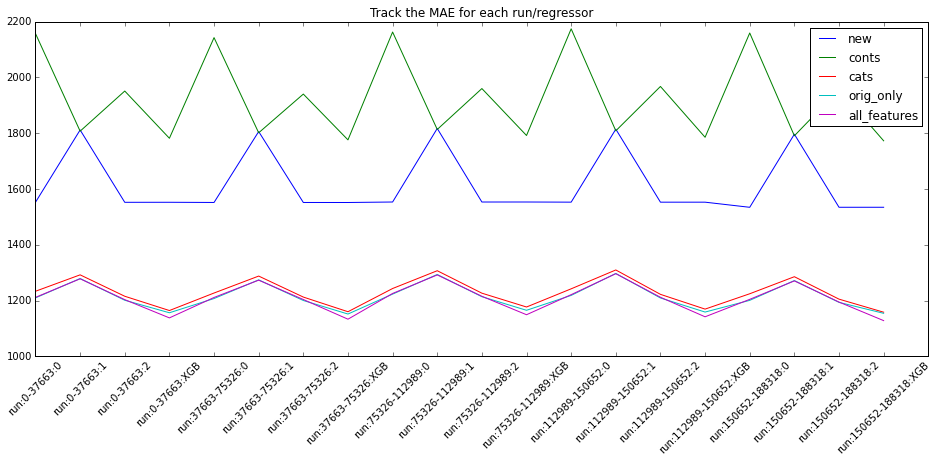

In [24]:
# let's get an idea of the layer 1 results.
plt.figure(figsize=(16,6))
for data_name in data_sets[:]:
    print "-----------Starting graphs for {} in layer1-----------".format(data_name)
    MAE_tracking_graph=np.array(joblib.load(cachedir+'MAE_tracking-{}.npy'.format(data_name))) 
    print(MAE_tracking_graph.T)
    plt.plot(MAE_tracking_graph.T[1],label=data_name)
    
plt.legend()
plt.title("Track the MAE for each run/regressor")
plt.xticks(range(len(MAE_tracking_graph.T[0])),MAE_tracking_graph.T[0], rotation=45)

plt.show()



### EOF